In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# [Densely Connected Networks (DenseNet)](https://d2l.ai/chapter_convolutional-modern/densenet.html)

In [2]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found e

The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation.

![image](https://d2l.ai/_images/densenet-block.svg)

ResNet

$$
f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).
$$

DenseNet

$$
\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), f_3\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right), f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right)\right]\right), \ldots\right].
$$

Dense connections in DenseNet. Note how the dimensionality increases with depth.

![img](https://d2l.ai/_images/densenet.svg)

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def conv_block(num_channels):
    # batch normalization, activation, and convolution
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [6]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [7]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [8]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [9]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

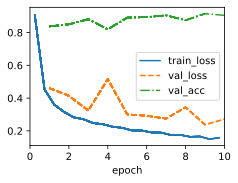

In [11]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## DenseNet

**DenseNet** 由 **Dense Block** 和 **Transition Block** 交替组成。它们分别承担不同的功能，构成 DenseNet 的核心设计。下面是它们的具体作用：

------

### **1. Dense Block**

#### **作用**

- **密集连接**：在一个 Dense Block 中，每一层都与之前所有的层直接相连。这种连接方式称为**密集连接**，通过特征重用减少冗余并提高梯度流动。
- **特征学习**：Dense Block 的目标是高效学习输入特征的丰富表征，同时避免信息的丢失。

#### **特性**

- 每一层接收来自所有前面层的特征作为输入，并将自己的输出传递给后续所有层。

- 输出公式为： 
  $$
  x_l = H_l([x_0, x_1, \dots, x_{l-1}])
  $$
   其中 $H_l$ 是第 $l$ 层的非线性变换，$\cdot$ 表示特征拼接操作。

#### **优点**

1. 特征复用：
   - 避免冗余特征的重复计算。
   - 提高特征的表示能力。
2. 缓解梯度消失：
   - 由于每层都与前面所有层相连，梯度可以直接传递给早期层。
3. 参数效率高：
   - 通过特征共享减少参数量，相比传统的深度网络更高效。

------

### **2. Transition Block**

#### **作用**

- **特征通道数的压缩**：通过 $1 \times 1$ 卷积减少通道数，控制模型复杂度。
- **下采样**：通过 $2 \times 2$ 的平均池化层实现下采样，减少特征图的空间维度。
- **连接 Dense Block**：在 Dense Block 之间插入 Transition Block，以便管理网络深度和宽度。

#### **特性**

- Transition Block 是一个包含 $1 \times 1$ 卷积层和池化层的小模块：

  1. **$1 \times 1$ 卷积**：调整通道数，降低计算量。
  2. **池化层**：通常是 $2 \times 2$ 平均池化，用于下采样。

- 输出公式为：
  $$
  x′ = \text{Pool}(\text{Conv1x1}(x))
  $$

#### **优点**

1. 控制模型复杂度：
   - 降低通道数，减小参数量和计算成本。
2. 减少特征尺寸：
   - 通过下采样逐渐减小特征图的大小，提高计算效率。
3. 分隔 Dense Block：
   - 防止 Dense Block 堆叠过多导致的内存和计算成本过高。

------

### **DenseNet 的设计逻辑**

- **Dense Block**：专注于特征提取，通过密集连接实现高效特征复用和梯度传递。
- **Transition Block**：用于调整网络的宽度和深度，通过通道压缩和下采样平衡计算效率和模型表达能力。

------

### **总结**

- Dense Block：
  - **功能**：特征复用，学习丰富表征。
  - **结构**：每一层接收之前所有层的输出。
- Transition Block：
  - **功能**：通道压缩与下采样，控制模型复杂度。
  - **结构**：包含 $1 \times 1$ 卷积和池化层。

这种设计让 DenseNet 在减少参数量的同时保持了强大的特征表达能力和优异的梯度流动特性。